# Proyek Analisis Data : PRSA_Data_Nongzhanguan_20130301-20170228
- **Nama:** Anugerah Surya Atmaja
- **Email:** atmajasuryaanugerah@gmail.com
- **ID Dicoding:** anugerahsurya

## Menentukan Pertanyaan Bisnis

- Apakah terdapat pola harian dan musiman dalam data polusi udara yang ditinjau dari PM2.5?
- Apakah terdapat hubungan antara variabel meteorologi lain dengan perubahan pada variabel PM2.5?

## Import Semua Packages/Library yang Digunakan

In [2]:
# Library umum untuk pengelolaan file dan data
import os
import numpy as np
import pandas as pd

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk analisis statistik
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Library untuk pembentukan model ARIMAX dan EGARCH
from arch import arch_model
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Untuk menghilangkan item warning ataupun peringatan yang mengganggu output kode
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/home/anugerahsurya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Data Wrangling

### Gathering Data

In [3]:
# Path ke folder yang berisi file CSV
path = "PRSA_Data_20130301-20170228"
def concat_data(folder_path):
    # List semua file CSV di dalam folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    def process_csv(file_path):
        df = pd.read_csv(file_path)
        df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
        return df
    # Proses setiap file dan simpan dalam list
    dfs = [process_csv(os.path.join(folder_path, file)) for file in csv_files]
    # Concatenate semua DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    print("Penggabungan selesai.")
    return merged_df

def missing_data(df):
    # Menampilkan baris yang memiliki setidaknya satu nilai yang hilang
    missing_rows = df[df.isnull().any(axis=1)]
    return missing_rows

dataset = concat_data(path)

Penggabungan selesai.


In [4]:
dataset

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong,2017-02-28 19:00:00
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong,2017-02-28 20:00:00
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong,2017-02-28 21:00:00
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong,2017-02-28 22:00:00


**Insight:** <br>
Berdasarkan proses penggabungan data yang dilakukan, diperoleh beberapa poin sebagai berikut.
- Data yang digunakan dapat dikategorikan data Panel, hal ini karena terdapat beberapa periode waktu untuk observasi yang sama, dimana pada kasus ini dinyatakan dengan Station Pengamatan.
- Jumlah observasi sebanyak 420768 secara keseluruhan, diikuti dengan 19 kolom yang menyatakan variabel cuaca, meteorologi, waktu, serta keterangan observasi.
- Data waktu yang digunakan berada di skala Jam. Hal ini dapat menjadi indikasi awal dalam meninjau perubahan cenderung smooth karena periode waktu pengumpulan data cukup cepat.
- Terdapat 12 Stasiun Pengamatan yang masing-masingnya diambil sebanyak 35064 periode waktu.
- Terdapat 18 kolom numerik dan 1 kolom kategorik.

#### Mengidentifikasi Observasi dengan Missing Value

In [5]:
data_missing = missing_data(dataset)
data_missing

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
74,75,2013,3,4,2,34.0,62.0,NaN,14.0000,300.0,68.0,8.1,1016.7,-11.8,0.0,N,4.3,Aotizhongxin,2013-03-04 02:00:00
75,76,2013,3,4,3,12.0,34.0,6.0000,12.0000,NaN,77.0,7.2,1016.9,-11.6,0.0,N,2.8,Aotizhongxin,2013-03-04 03:00:00
76,77,2013,3,4,4,7.0,18.0,14.0000,NaN,400.0,42.0,6.0,1018.0,-11.6,0.0,NNW,1.0,Aotizhongxin,2013-03-04 04:00:00
124,125,2013,3,6,4,192.0,203.0,83.6808,140.4252,NaN,22.0,3.9,1007.3,-6.1,0.0,NE,1.4,Aotizhongxin,2013-03-06 04:00:00
170,171,2013,3,8,2,339.0,400.0,NaN,162.0000,3899.0,84.0,2.5,998.2,-1.9,0.0,SW,0.8,Aotizhongxin,2013-03-08 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420732,35029,2017,2,27,12,NaN,NaN,NaN,NaN,NaN,NaN,12.1,1017.3,-5.4,0.0,SSW,1.2,Wanshouxigong,2017-02-27 12:00:00
420733,35030,2017,2,27,13,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1015.8,-5.2,0.0,SSE,1.8,Wanshouxigong,2017-02-27 13:00:00
420758,35055,2017,2,28,14,3.0,6.0,NaN,5.0000,NaN,82.0,14.6,1013.3,-15.6,0.0,N,3.6,Wanshouxigong,2017-02-28 14:00:00
420759,35056,2017,2,28,15,11.0,21.0,2.0000,5.0000,200.0,NaN,15.4,1013.0,-15.0,0.0,NNW,3.3,Wanshouxigong,2017-02-28 15:00:00


**Insight :** <br>
Dalam mempersiapkan data, diperlukan tahapan untuk mengidentifikasi bahwa suatu data sudah dapat diolah. Hal pertama yang dapat dilakukan berupa identifikasi missing value. Berkaitan dengan jenis data yang digunakan, tentu diperlukan *treatment* berbeda dalam memproses missing value yang ditemukan. Berdasarkan pengecekan yang dilakukan diperoleh 38600 observasi dengan missing value.

#### Imputasi Missing Value pada Kolom Numerik menggunakan Interpolasi, Forward Fill, dan Backward Fill untuk masing-masing station 

In [6]:
# Gabungkan menjadi datetime
dataset['datetime'] = pd.to_datetime(dataset[['year', 'month', 'day', 'hour']])

# Hapus kolom tahun, bulan, hari, jam (opsional)
datasetBaru = dataset.drop(columns=['year', 'month', 'day', 'hour'])

# Pastikan DataFrame tersortir
datasetBaru = datasetBaru.sort_values(by=['station', 'datetime'])

# Identifikasi kolom numerik selain 'station' dan 'datetime'
numeric_cols = datasetBaru.select_dtypes(include=['number']).columns

# Imputasi missing values dengan interpolasi + ffill/bfill menggunakan transform()
datasetBaru[numeric_cols] = datasetBaru.groupby('station')[numeric_cols].transform(lambda x: x.interpolate().ffill().bfill())


**Insight :** <br>
Berdasarkan missing value yang ditemukan, dilakukan imputasi terhadap isian yang hilang. Imputasi akan memperhatikan titik waktu pada masing-masing stasiun pengamatan. Sehingga data akan dikelompokkan berdasarkan stasiun amatan, yang selanjutnya diimputasi menggunakan metode yang umum diterapkan pada data runtun waktu. Pada penelitian ini dilakukan imputasi dengan Interpolasi di awal. Mekanisme ini mempertimbangkan observasi t-1 dan t+1 yang selanjutnya digunakan untuk imputasi observasi ke-t. Jika salah satu dari observasi t-1 dan t+1 kosong, maka akan digunakan Forward Fill dan/atau Backward Fill. Metode ini mengambil nilai sebelum dan sesudah data tertentu. Tahapan imputasi tersebut digunakan untuk data dengan isian Numerik. 

#### Imputasi Missing Value pada Kolom Kategorik dengan Forward Fill dan Backward Fill

In [7]:
categorical_cols = datasetBaru.select_dtypes(include=['object']).columns

# Imputasi untuk kolom kategorik (Hanya ffill + bfill)
datasetBaru[categorical_cols] = datasetBaru.groupby('station')[categorical_cols].transform(lambda x: x.ffill().bfill())

Pada data dengan isian kategorik, imputasi akan menggunakan Forward Fill (pertama) da Backward Fill. Interpolasi tidak digunakan karena membutuhkan data numerik. Selain itu imputasi kategori seperti Modus juga tidak digunakan, karena cenderung kurang representatif pada data Runtun Waktu.

### Assessing Data

#### Distribusi PM2.5 untuk masing-masing Station

In [8]:
descriptive_stats = datasetBaru.groupby('station')['PM2.5'].agg(['min', 'max', 'mean', 'median'])
print(descriptive_stats)

               min    max       mean  median
station                                     
Aotizhongxin   3.0  898.0  82.540623    58.0
Changping      2.0  882.0  70.986438    46.0
Dingling       3.0  881.0  66.845557    41.0
Dongsi         3.0  737.0  86.144243    61.0
Guanyuan       2.0  680.0  82.897522    59.0
Gucheng        2.0  770.0  84.074802    60.0
Huairou        2.0  762.0  69.501747    47.0
Nongzhanguan   2.0  844.0  85.079472    59.0
Shunyi         2.0  941.0  79.437962    55.0
Tiantan        3.0  821.0  82.033097    58.0
Wanliu         2.0  957.0  83.467612    59.0
Wanshouxigong  3.0  999.0  85.067548    60.0


#### Distribusi PM10 untuk masing-masing station

In [9]:
descriptive_stats = datasetBaru.groupby('station')['PM10'].agg(['min', 'max', 'mean', 'median'])
print(descriptive_stats)


               min    max        mean  median
station                                      
Aotizhongxin   2.0  984.0  110.210033    87.0
Changping      2.0  999.0   94.788575    72.0
Dingling       2.0  905.0   84.113713    60.0
Dongsi         2.0  955.0  110.347617    86.0
Guanyuan       2.0  999.0  109.372349    89.0
Gucheng        2.0  994.0  119.261567   100.0
Huairou        2.0  993.0   92.422670    69.0
Nongzhanguan   2.0  995.0  109.384022    85.0
Shunyi         2.0  999.0   99.271936    77.0
Tiantan        2.0  988.0  106.537076    85.0
Wanliu         2.0  951.0  110.707858    88.0
Wanshouxigong  2.0  961.0  112.505795    91.0


#### Distribusi CO untuk masing-masing station

In [10]:
descriptive_stats = datasetBaru.groupby('station')['CO'].agg(['min', 'max', 'mean', 'median'])
print(descriptive_stats)


                 min      max         mean       median
station                                                
Aotizhongxin   100.0  10000.0  1264.692405   900.000000
Changping      100.0  10000.0  1156.990246   800.000000
Dingling       100.0  10000.0   925.111838   600.000000
Dongsi         100.0  10000.0  1331.913045  1000.000000
Guanyuan       100.0  10000.0  1258.327045   900.000000
Gucheng        100.0  10000.0  1338.100060   985.714286
Huairou        100.0  10000.0  1019.671871   800.000000
Nongzhanguan   100.0  10000.0  1327.767611   900.000000
Shunyi         100.0  10000.0  1197.904660   900.000000
Tiantan        100.0  10000.0  1305.333262   900.000000
Wanliu         100.0  10000.0  1328.761180   900.000000
Wanshouxigong  100.0   9800.0  1373.618569  1000.000000


#### Distribusi Temperature untuk Masing-masing station

In [11]:
descriptive_stats = datasetBaru.groupby('station')['TEMP'].agg(['min', 'max', 'mean', 'median'])
print(descriptive_stats)


                min   max       mean  median
station                                     
Aotizhongxin  -16.8  40.5  13.581414    14.5
Changping     -16.6  41.4  13.671605    14.6
Dingling      -16.6  41.4  13.671605    14.6
Dongsi        -16.8  41.1  13.668250    14.6
Guanyuan      -16.8  40.5  13.581414    14.5
Gucheng       -15.6  41.6  13.855824    14.8
Huairou       -19.9  40.3  12.430556    13.5
Nongzhanguan  -16.8  41.1  13.668250    14.6
Shunyi        -16.8  40.6  13.375531    14.4
Tiantan       -16.8  41.1  13.668250    14.6
Wanliu        -15.8  40.5  13.425795    14.3
Wanshouxigong -16.8  40.6  13.781808    14.8


#### Distribusi Curah Hujan untuk Masing-masing station

In [12]:
descriptive_stats = datasetBaru.groupby('station')['RAIN'].agg(['min', 'max', 'mean', 'median'])
print(descriptive_stats)


               min   max      mean  median
station                                   
Aotizhongxin   0.0  72.5  0.067383     0.0
Changping      0.0  52.1  0.060293     0.0
Dingling       0.0  52.1  0.060293     0.0
Dongsi         0.0  46.4  0.063983     0.0
Guanyuan       0.0  72.5  0.067383     0.0
Gucheng        0.0  41.9  0.064374     0.0
Huairou        0.0  45.9  0.067950     0.0
Nongzhanguan   0.0  46.4  0.063983     0.0
Shunyi         0.0  37.3  0.061010     0.0
Tiantan        0.0  46.4  0.063983     0.0
Wanliu         0.0  72.5  0.068224     0.0
Wanshouxigong  0.0  46.4  0.064285     0.0


**Insight:**<br>
Dengan meninjau beberapa aspek yang berkaitan erat dengan Aktivitas Manusia serta Potensi Kerusakan lingkungan yang ditimbulkan oleh beberapa variabel diperoleh poin berikut.

##### Particulate Matter 2.5
| Kategori              | Rentang PM2.5 (µg/m³) |
|----------------------|--------------------|
| **Baik**            | 0 – 15             |
| **Sedang**          | 16 – 65            |
| **Tidak Sehat**     | 66 – 150           |
| **Sangat Tidak Sehat** | 151 – 250      |
| **Berbahaya**       | > 250              |

***Sumber : BMKG (2022)***
- Pada variabel PM2.5, terlihat bahwa nilai maksimum mencapat 700-800 microogram. Hal ini tentu menunjukkan kondisi polusi udara yang tinggi. Mengacu pada standar pengukuran status kualitas udara, nilai PM2.5 > 250 sudah berada di status berbahaya. 
- Nilai rata-rata PM2.5 untuk masing-masing stasiun berada di antara 60-90 microgram. Hal ini menunjukkan secara rataan, untuk pengukuran di seluruh stasiun observasi, kondisi udara cenderung Tidak Sehat. Hal ini menjadi indikasi perlu dilakukan perlakuan untuk membersihkan udara berupa penyiraman hujan buatan, atau menggunakan masker dalam beraktivitas.
- Median data lebih rendah dibanding rata-rata data. Hal ini menunjukkan bahwa terdapat Gap yang cukup besar antara nilai tinggi dan rendah, sehingga rataan lebih besar dibanding median.

##### Particulate Matter 10
- Pada variabel PM10 terlihat bahwa nilai maksimum berada di selang > 900. Hal ini menunjukkan kondisi yang berbahaya.
- Hal tersebut juga didukung dengan distribus yang sama dengan PM2.5 namun lebih tinggi, yaitu dengan rataan 90 - 120 microgram/m^3 dan median di selang 60 - 100 microgram.

##### Carbon Monoksida (CO)
- Pada variabel CO bahwa rataannya berada di selang 900 - 1400 untuk masing-masing stasiun. 
- Nilai minimumnya berada di 100 microgram/m^3.

##### Temperature
- Untuk masing-masing stasiun nilai minimum berada di -16 derajat celcius. Hal ini dapat terjadi karena China merupakan negara dengan 4 musim.
- Selain itu nilai maksimum berada di > 40 derajat celcius.
- Rata-rata berada di selang 11-13 derajat celcius. Hal ini menunjukkan kecenderungan udara berada di suhu lebih rendah dibanding suhu lebih tinggi.
- Berdasarkan nilai median juga dapat dilihat cenderung mendekati mean. Hal ini mengindikasikan sebaran nilai yang cukup merata untuk data suhu.

##### Rain
- Berdasarkan variabel curah hujan, nilai rata-rata untuk masing masing stasiun berada di < 0,07. Hal ini menunjukkan minimnya hujan di wilayah amatan pada masing-masing stasiun.
- Hal ini juga didukung dengan median 0. Artinya lebih dari setengah data untuk masing-masing stasiun bernilai 0.
- Kondisi ini yang mengindikasikan buruknya kualitas udara di wilayah observasi karena minimnya curah hujan karena umumnya curah hujan dapat membantu untuk membersihkan udara serta meminimalisir jumlah polusi.

### Cleaning Data

In [13]:
# Cek duplikasi berdasarkan kolom 'station' dan 'datetime'
duplikat = datasetBaru.duplicated(subset=['station', 'datetime'], keep=False)

if not duplikat.any():
    print("Tidak terdapat data yang terduplikasi pada Stasiun dan Titik Waktu Tertentu")
else:
    # Menampilkan observasi yang duplikat
    print("Ditemukan data yang terduplikasi pada Stasiun dan Titik Waktu :")
    print(datasetBaru[duplikat])


Tidak terdapat data yang terduplikasi pada Stasiun dan Titik Waktu Tertentu


**Insight:**<br>
Berdasarkan Tahapan yang dilakukan, Assesing Data diiringi dengan Cleaning data agar seluruh observasi dapat ditinjau secara lebih baik.
- Data yang memiliki missing value seluruhnya diimputasi, sehingga tidak ada pengurangan jumlah data yang digunakan.
- Imputasi mempertimbangkan titik waktu serta stasiun amatan terkait.
- Variabel year, month, day, dan hour digabung menjadi 1 variabel yaitu datetime, untuk mempermudah analisis.
- Selain itu dilakukan pengecekan duplikasi berdasarkan stasiun dan titik waktu yang sama. Hal ini dipilih untuk mengefisienkan proses, karena nilai tersebut yang menjadi primary key pada data panel ini. 

## Exploratory Data Analysis (EDA)

### Eksplorasi jumlah periode yang dikelompokkan berdasarkan klasifikasi kualitas udara menurut kadar PM2.5

In [14]:
# Fungsi untuk mengkategorikan PM2.5
def kategori_pm25(value):
    if value <= 15:
        return "Baik"
    elif value <= 65:
        return "Sedang"
    elif value <= 150:
        return "Tidak Sehat"
    elif value <= 250:
        return "Sangat Tidak Sehat"
    else:
        return "Berbahaya"

# Grouping berdasarkan station dan menghitung distribusi kategori PM2.5
eksplorasi_pm25 = datasetBaru.groupby("station")["PM2.5"].apply(lambda x: x.apply(kategori_pm25).value_counts()).unstack().fillna(0)

# Fungsi untuk menyorot nilai tertinggi (merah) dan terendah (hijau)
def highlight_max_min(s):
    max_val = s.max()
    min_val = s.min()
    return [
        'font-weight: bold; color: red' if v == max_val else 
        'font-weight: bold; color: green' if v == min_val else '' 
        for v in s
    ]

# Menampilkan hasil eksplorasi dengan format bold untuk nilai tertinggi dan terendah
styled_eksplorasi_pm25 = eksplorasi_pm25.style.apply(highlight_max_min, axis=0)

styled_eksplorasi_pm25

,Baik,Berbahaya,Sangat Tidak Sehat,Sedang,Tidak Sehat
station,,,,,
Aotizhongxin,6240,1679,3939,12727,10479
Changping,7501,1128,3298,13848,9289
Dingling,9619,1173,3000,12857,8415
Dongsi,6384,1941,4059,11987,10693
Guanyuan,5824,1603,3907,13021,10709
Gucheng,5950,1690,3882,12648,10894
Huairou,7847,993,3153,13607,9464
Nongzhanguan,6523,1954,3997,12234,10356
Shunyi,7190,1575,3789,12439,10071


### Eksplorasi jumlah periode yang dikelompokkan berdasarkan klasifikasi kualitas udara menurut kadar PM10

In [15]:
# Grouping berdasarkan station dan menghitung distribusi kategori PM2.5
eksplorasi_pm10 = datasetBaru.groupby("station")["PM10"].apply(lambda x: x.apply(kategori_pm25).value_counts()).unstack().fillna(0)

# Fungsi untuk menyorot nilai tertinggi (merah) dan terendah (hijau)
def highlight_max_min(s):
    max_val = s.max()
    min_val = s.min()
    return [
        'font-weight: bold; color: red' if v == max_val else 
        'font-weight: bold; color: green' if v == min_val else '' 
        for v in s
    ]

# Menampilkan hasil eksplorasi dengan format bold untuk nilai tertinggi dan terendah
styled_eksplorasi_pm10 = eksplorasi_pm10.style.apply(highlight_max_min, axis=0)

styled_eksplorasi_pm10

,Baik,Berbahaya,Sangat Tidak Sehat,Sedang,Tidak Sehat
station,,,,,
Aotizhongxin,2841,2841,6284,11114,11984
Changping,2976,1898,4844,13252,12094
Dingling,4979,1547,4161,13556,10821
Dongsi,3072,2942,5809,10869,12372
Guanyuan,2512,2609,6040,11084,12819
Gucheng,2734,3119,7491,9459,12261
Huairou,4560,1809,5041,12299,11355
Nongzhanguan,2912,2880,5761,11046,12465
Shunyi,4355,2228,5391,11157,11933


**Insight:** <br>
- Dengan meninjau Particulate Matter yang menjadi indikator yang berkaitan erat dengan Air Quality Index (AQI), diperoleh bahwa untuk keseluruhan wilayah, klasifikasi PM2.5 untuk kategori sedang lebih tinggi dibanding kategori lainnya. Selain itu untuk kategori **sedang**, **stasiun Changping** menjadi stasiun dengan **kategori sedang tertinggi**. Selain itu untuk kategori Berbahaya, **stasiun Nongzhanguan** menjadi stasiun dengan **jumlah kategori tertinggi**. Hal ini menunjukkan **kecenderungan tingginya pencemaran udara** di wilayah terkait.
- Dengan meninjau Particulate Matter yang menjadi indikator yang berkaitan erat dengan Air Quality Index (AQI), diperoleh bahwa untuk wilayah **Aotizhongxin, Dongsi, Guanyuan, Gucheng, Nongzhanguan, Shunyi, Tiantan, Wanliu, dan Wanshouxigong** klasifikasi untuk kondisi Tidak Sehat dari PM10 jika mengacu pada klasifikasi PM2.5, lebih banyak dibanding kategori lainnya. Sedangkan daerah Changping dan Huairou, klasifikasi Sedang lebih tinggi namun tidak berbeda signifikan dengan jumlah klasifikasi Tidak Sehat. 
- Untuk nilai PM10 pada klasifikasi berbahaya dengan mengacu pada acuan klasifikasi PM2.5, **stasiun Gucheng** menjadi stasiun dengan **jumlah tangkapan kategori Berbahaya tertinggi**. Selain itu **stasiun Dingling** menjadi stasiun dengan **jumlah tangkapan kategori baik tertinggi**. Hal ini juga ditunjukkan dengan **nilai kategori lain yang didominasi oleh nilai terendah dibanding stasiun-stasiun lainnya**. Hal ini menunjukkan wilayah tersebut memiliki **kondisi yang lebih baik.**

## Visualization & Explanatory Analysis

### Pertanyaan 1 : 

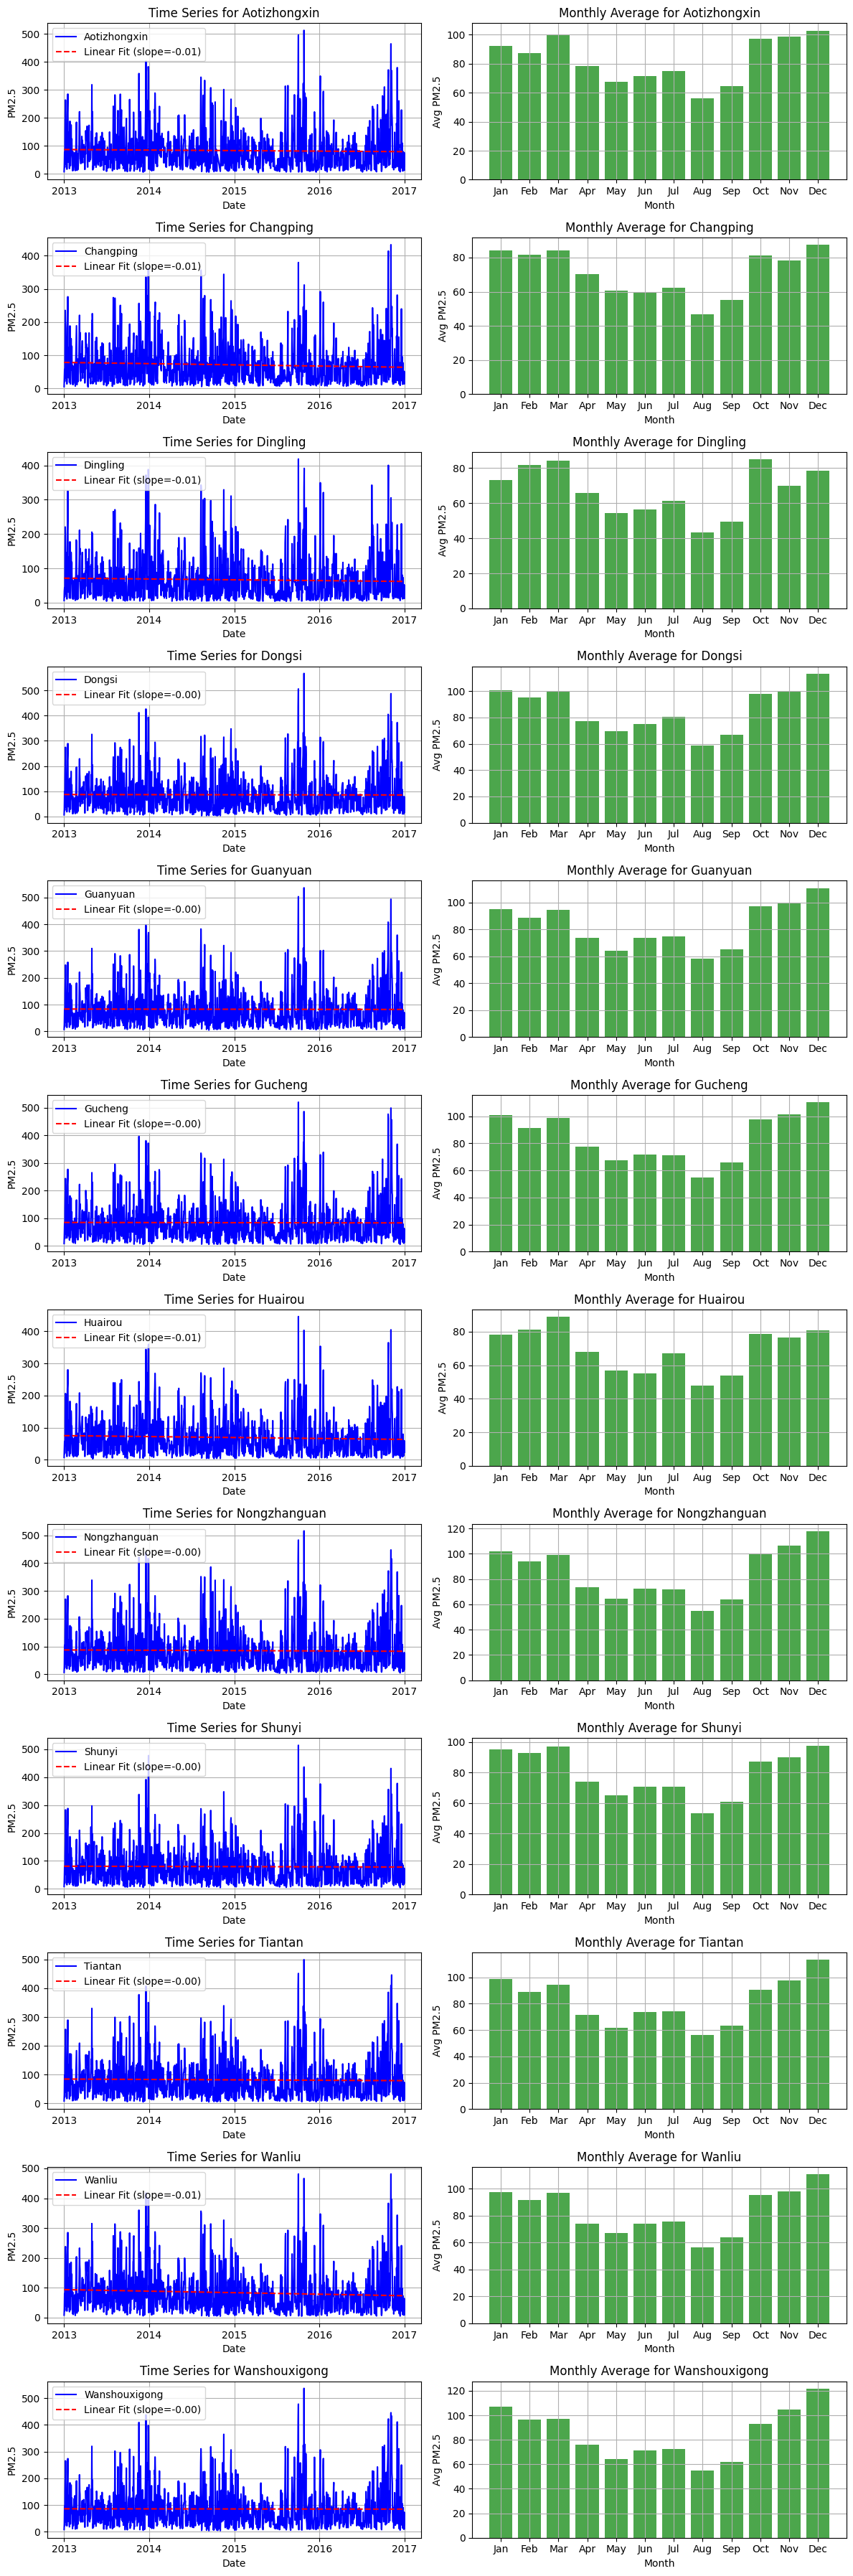

In [16]:
# Ubah datetime ke format harian
df_daily = datasetBaru.copy()
df_daily["datetime"] = pd.to_datetime(df_daily["datetime"]).dt.date  # Ambil hanya tanggalnya

# Pisahkan kolom numerik dan kategorik
numeric_cols = df_daily.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df_daily.select_dtypes(include=["object", "category"]).columns.tolist()

# Grupkan berdasarkan station dan datetime
agg_funcs = {col: "mean" for col in numeric_cols}  # Gunakan mean untuk numerik
agg_funcs.update({col: lambda x: x.mode().iloc[0] if not x.mode().empty else None for col in categorical_cols})  # Gunakan modus untuk kategorik

df_daily = df_daily.groupby(["station", "datetime"], as_index=False).agg(agg_funcs)

# Pastikan datetime kembali dalam format datetime64 agar bisa digunakan dalam analisis time series
df_daily["datetime"] = pd.to_datetime(df_daily["datetime"])

def plot_time_series(df, station_col, datetime_col, value_col):
    # Mendapatkan daftar stasiun unik
    stations = df[station_col].unique()
    
    # Tentukan jumlah kolom dan baris untuk subplot (2 kolom)
    num_stations = len(stations)
    num_cols = 2
    num_rows = (num_stations + 1) // num_cols
    
    # Membuat plot dengan jumlah subplot sesuai jumlah stasiun
    fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(12, 6 * num_rows))  # 2 baris untuk setiap stasiun
    
    # Pastikan axes adalah array meskipun hanya ada satu subplot
    axes = axes.flatten()
    
    # Iterasi untuk setiap stasiun dan buat diagram garis serta bar chart
    for i, station in enumerate(stations):
        ax_ts = axes[2 * i]  # Grafik time series
        ax_bar = axes[2 * i + 1]  # Bar chart per bulan
        
        station_data = df[df[station_col] == station].copy()  # Pastikan menggunakan salinan (copy)
        
        # Plot data untuk time series
        ax_ts.plot(station_data[datetime_col], station_data[value_col], label=f"{station}", color='b')
        
        # Menambahkan garis regresi linier
        x_vals = (station_data[datetime_col] - station_data[datetime_col].min()).dt.days.values  # Mengubah datetime menjadi angka hari
        y_vals = station_data[value_col].values
        slope, intercept, r_value, p_value, std_err = linregress(x_vals, y_vals)
        ax_ts.plot(station_data[datetime_col], slope * x_vals + intercept, color='r', linestyle='--', label=f'Linear Fit (slope={slope:.2f})')  # Menambahkan slope ke label
        
        # Menambahkan judul dan label untuk time series
        ax_ts.set_title(f"Time Series for {station}")
        ax_ts.set_xlabel("Date")
        ax_ts.set_ylabel(value_col)
        ax_ts.legend(loc="upper left")
        ax_ts.grid(True)
        
        # Menampilkan label x hanya setiap tahun
        ax_ts.set_xticks(station_data[datetime_col][::365].values)  # Setiap tahun
        ax_ts.set_xticklabels(station_data[datetime_col][::365].dt.year.values)  # Menampilkan tahun saja
        
        # Bar chart untuk rata-rata per bulan
        station_data["month"] = station_data[datetime_col].dt.month  # Menggunakan .loc tidak lagi diperlukan
        monthly_avg = station_data.groupby("month")[value_col].mean()
        
        ax_bar.bar(monthly_avg.index, monthly_avg.values, color='g', alpha=0.7)
        ax_bar.set_title(f"Monthly Average for {station}")
        ax_bar.set_xlabel("Month")
        ax_bar.set_ylabel(f"Avg {value_col}")
        ax_bar.set_xticks(np.arange(1, 13))  # Bulan 1 sampai 12
        ax_bar.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
        ax_bar.grid(True)
    
    # Atur layout untuk subplot
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk membuat visualisasi
plot_time_series(df_daily, station_col="station", datetime_col="datetime", value_col="PM2.5")


**Insight :**<br>
Berdasarkan analisis yang dilakukan melalui visualisasi dengan diagram garis untuk masing-masing stasiun pengamatan pada setiap titik waktu diperoleh hal berikut.
- Terdapat nilai yang berfluktuatif dari data harian polusi udara saat ditinjau melalui kadar PM2.5 di masing-masing wilayah.
- Terdapat pola musiman untuk seluruh stasiun pengamatan, dimana terdapat peningkatan kadar PM2.5 pada periode akhir tahun. 
- Hal ini dapat dilihat pada visualisai bar chart rataan bulanan untuk masing-masing stasiun. Nilai PM2.5 meningkat di periode akhir tahun. Secara umum, nilai PM2.5 terendah berada pada bulan agustus. Berdasarkan identifikasi yang dilakukan [Sumber Data](https://seasonsyear.com/China), diketahui agustus merupakan musim semi. Hal ini bisa menjadi penyebab nilai PM2.5 menurun karena tingginya curah hujan, suhu udara yang relatif normal, kelembapan yang cukup, sehingga meminimalisir peningkatan PM2.5.
- Berdasarkan sumber yang ditemukan, periode akhir dan awal tahun merupakan kondisi untuk musim Gugur dan musim Dingin. Hal ini dapat saja meningkatkan kadar PM2.5 karena peningkatan penggunaan pemanas pada musim dingin, serta aktivitas mobilitas yang cukup tinggi di musim gugur.

### Pertanyaan 2: Bagaimana pengaruh antara masing-masing variabel terhadap PM2.5?

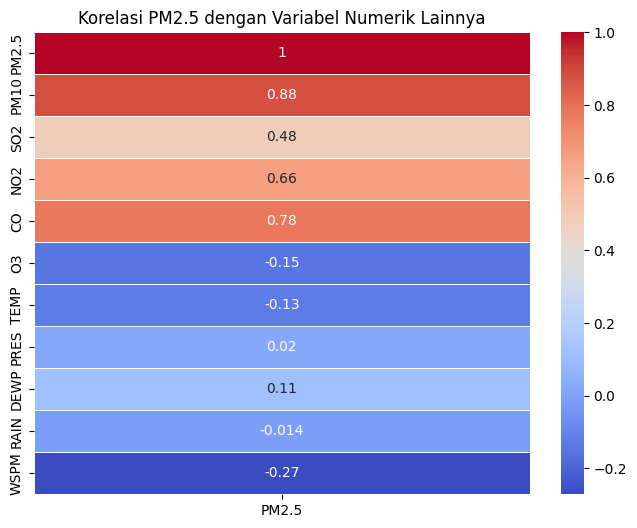

In [17]:
# Select only numeric columns
numeric_columns = datasetBaru.select_dtypes(include=['number']).drop(columns=['No'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Extract the correlation of PM2.5 with other columns
pm25_correlation = correlation_matrix['PM2.5']

# Plot heatmap korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(pm25_correlation.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korelasi PM2.5 dengan Variabel Numerik Lainnya")
plt.show()


**Insight:**
- Berdasarkan analisis yang dilakukan menggunakan korelasi pearson terlihat hubungan yang beragam untuk masing-masing variabel terhadap variabel PM2.5 secara keseluruhan.
- Untuk variabel yang berwujud gas yang umumnya digunakan sebagai ukuran penyusun Aerosol Optical Depth (AOD), hubungan variabel tersebut dengan PM2.5 jika diukur secara linier adalah **positif**.
- Nilai tersebut sesuai karena variabel tersebut yang menjadi indikator pendeteksian kualitas udara, dimana tingginya nilai variabel terkait mengindikasikan buruknya kualitas udara. Hal ini menunjukkan bahwa variabel pendukung dapat menjelaskan variasi dari data PM2.5.
- Variabel seperti Windspeed, RAIN memiliki hubungan negatif. Hal ini terjadi karena rendahnya intensitas hujan serta rendahnya kecepatan angin dapat menyebabkan buruknya kualitas udara. Hujan yang umumnya dapat menjadi media untuk membersihkan udara tentu berperan dalam meminimalisir polusi udara. Selain itu rendahnya kecepatan angin, membuat partikel polusi terperangkap di suatu wilayah.
- Dengan meninjau tingginya korelasi antara variabel pendukung dengan PM2.5, tentu pemerintah dapat mengontrol PM2.5 dengan juga memperhatikan perkembangan variabel pendukung ini. Salah satunya CO, dimana sering dihasilkan di asap pembakaran dan bahan bakar. Pemberlakuan CFD ataupun kampanye penggunaan kendaraan listrik tentu dapat menjadi langkah yang tepat untuk meminimalisir tingginya PM2.5.

### Pertanyaan 3: Bagaimana sebaran kategori PM2.5 untuk Stasiun Dingling setiap harinya?

/tmp/ipykernel_1575/2932830630.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'year'] = filtered_data['datetime'].dt.year
/tmp/ipykernel_1575/2932830630.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'month'] = filtered_data['datetime'].dt.month
/tmp/ipykernel_1575/2932830630.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

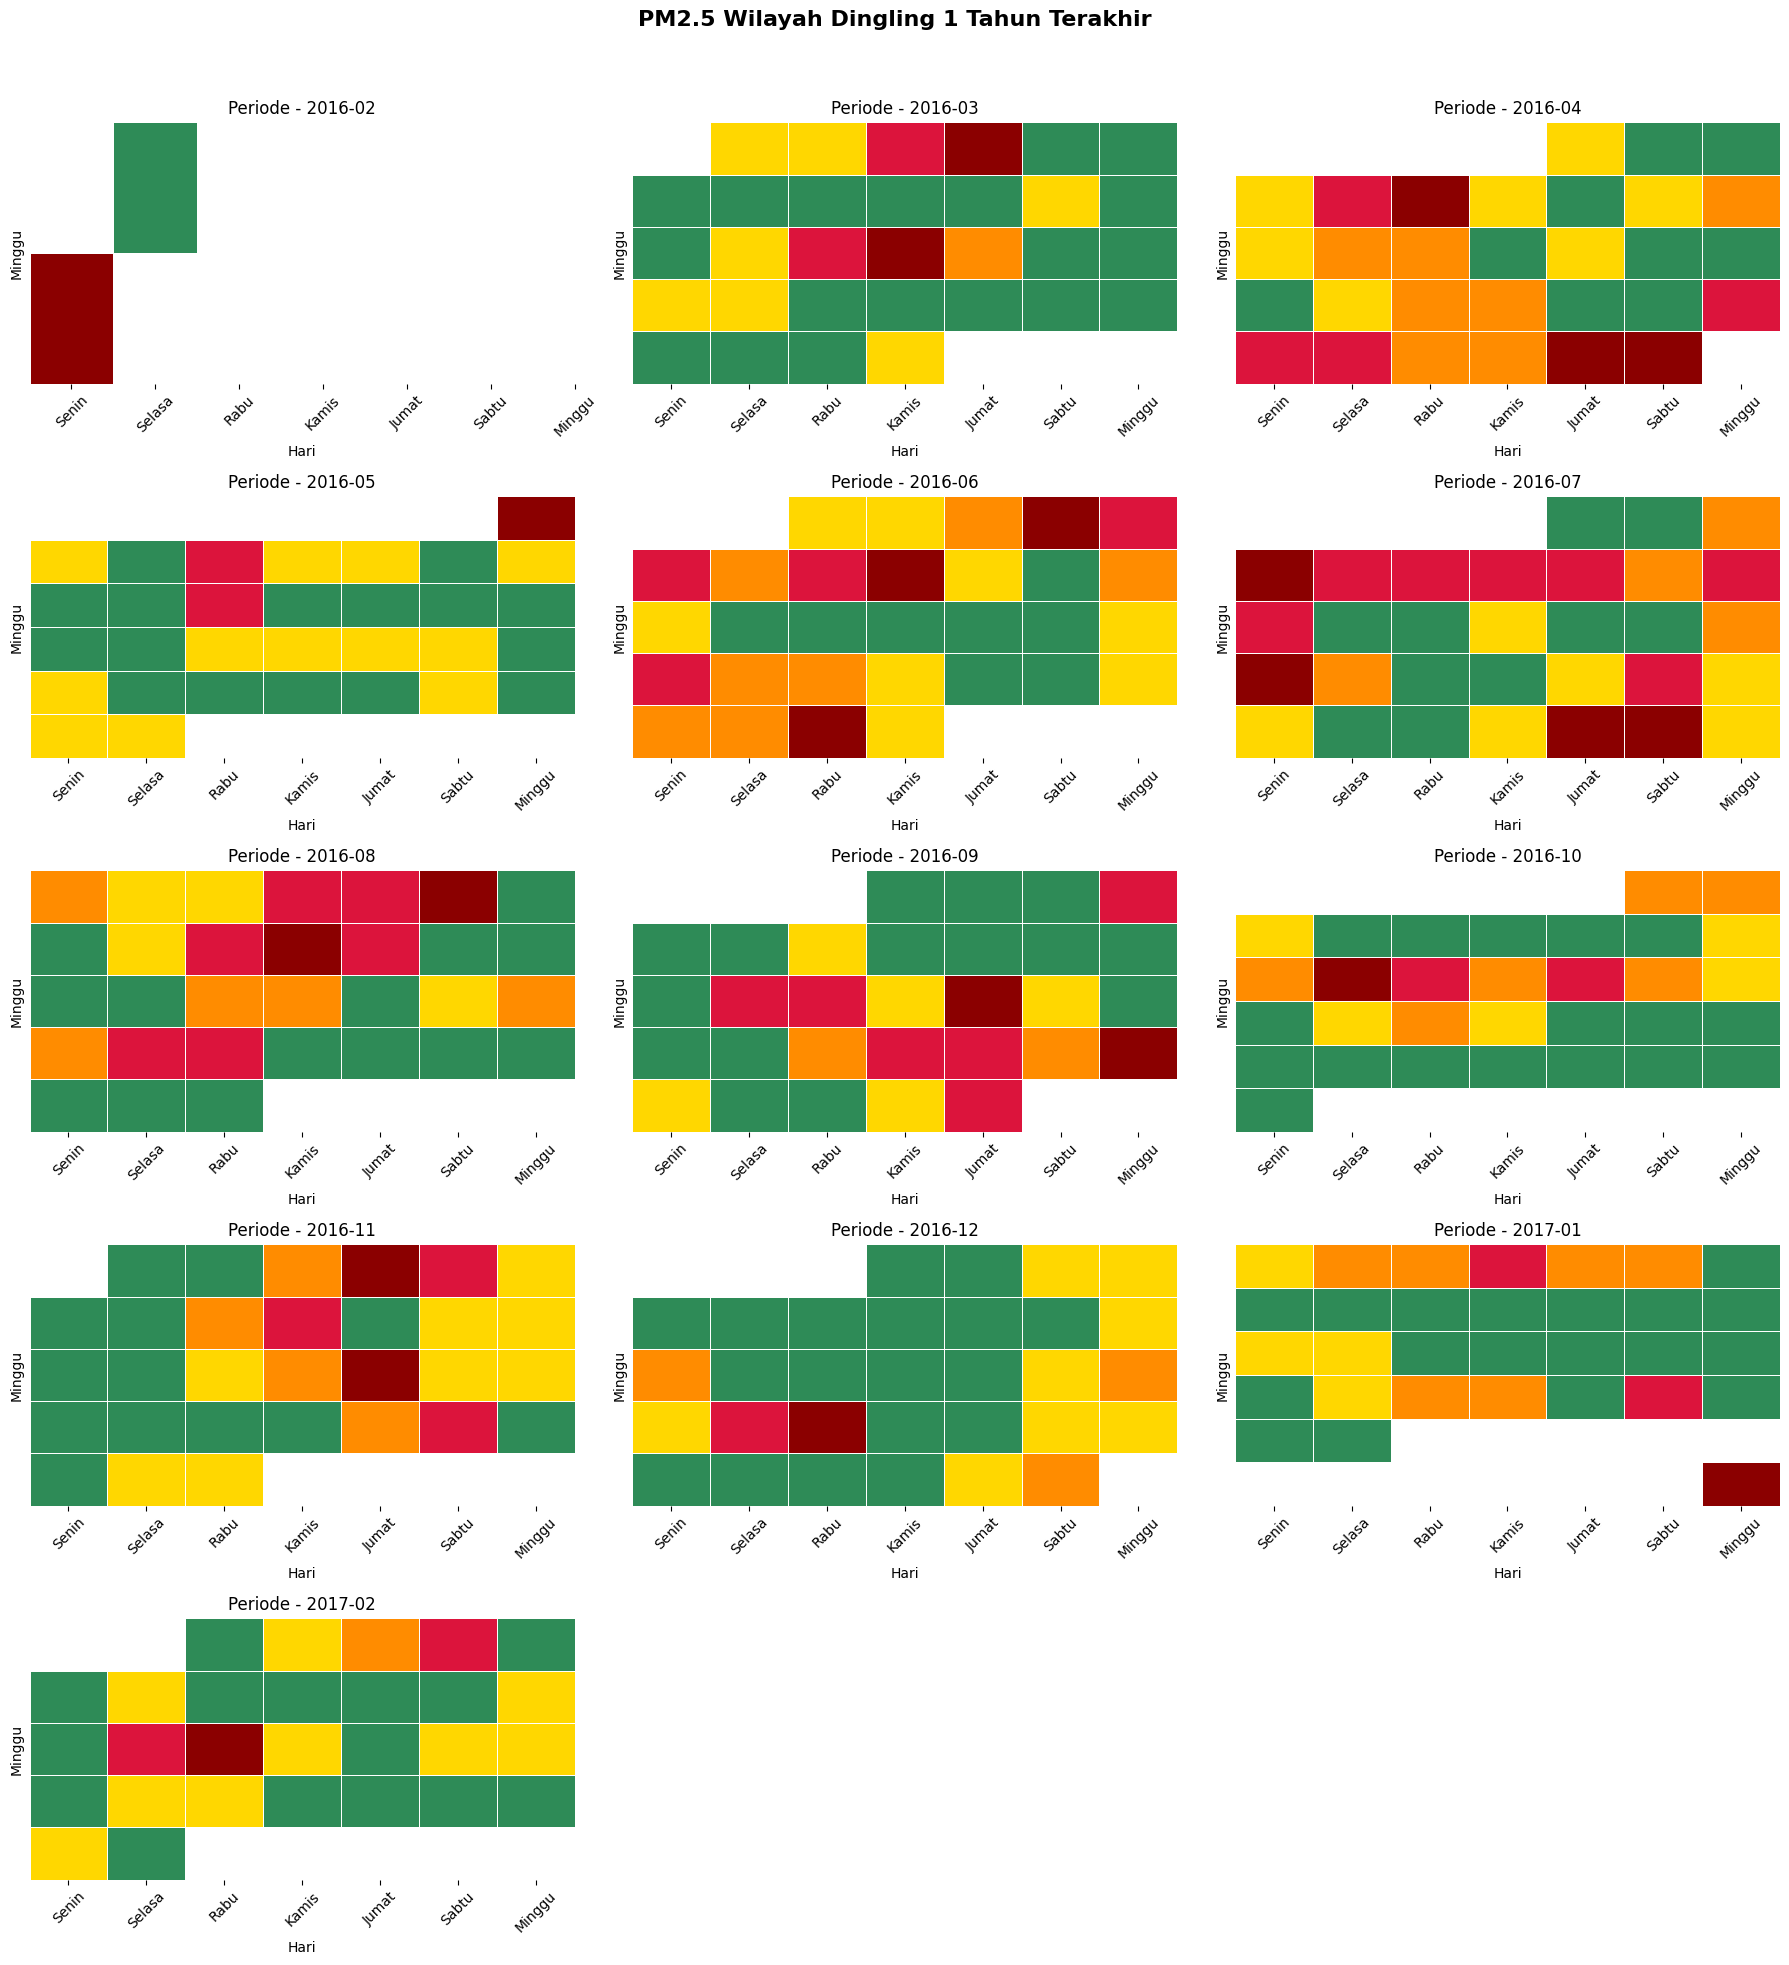

In [18]:
# Contoh fungsi kategori PM2.5
def kategori_pm25(value):
    if value <= 15:
        return "Baik"
    elif value <= 65:
        return "Sedang"
    elif value <= 150:
        return "Tidak Sehat"
    elif value <= 250:
        return "Sangat Tidak Sehat"
    else:
        return "Berbahaya"

# Warna sesuai kategori status bahaya mulai dari Hijau (aman) hingga Merah (bahaya)
kategori_warna = {
    "Baik": "#2E8B57",
    "Sedang": "#FFD700",
    "Tidak Sehat": "#FF8C00",
    "Sangat Tidak Sehat": "#DC143C",
    "Berbahaya": "#8B0000"
}


# Filter data untuk station 'Dingling' dan 1 tahun terakhir
end_date = datasetBaru['datetime'].max()
start_date = end_date - pd.DateOffset(years=1)
filtered_data = datasetBaru[(datasetBaru['station'] == 'Dingling') &
                            (datasetBaru['datetime'] >= start_date)]

# Buat kolom tambahan untuk tahun, bulan, hari, dan minggu
filtered_data.loc[:, 'year'] = filtered_data['datetime'].dt.year
filtered_data.loc[:, 'month'] = filtered_data['datetime'].dt.month
filtered_data.loc[:, 'week'] = filtered_data['datetime'].dt.isocalendar().week
filtered_data.loc[:, 'day'] = filtered_data['datetime'].dt.dayofweek  # 0 = Senin, 6 = Minggu
filtered_data.loc[:, 'category'] = filtered_data['PM2.5'].apply(kategori_pm25)

# Mapping angka ke nama hari
hari_labels = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']

# Membuat subplot dengan layout 3 kolom
unique_months = filtered_data[['year', 'month']].drop_duplicates().sort_values(by=['year', 'month'])
n_months = len(unique_months)
fig, axes = plt.subplots((n_months // 3) + (n_months % 3 > 0), 3, figsize=(18, (n_months // 3) * 5))
axes = axes.flatten()

# Tambahkan judul utama
fig.suptitle("PM2.5 Wilayah Dingling 1 Tahun Terakhir", fontsize=16, fontweight='bold')

# Loop untuk membuat heatmap per bulan
for i, (year, month) in enumerate(unique_months.itertuples(index=False)):
    monthly_data = filtered_data[(filtered_data['year'] == year) & (filtered_data['month'] == month)]
    if monthly_data.empty:
        continue
    
    # Pivot tabel: baris = minggu, kolom = hari
    heatmap_data = monthly_data.pivot_table(index='week', columns='day', values='PM2.5')
    
    # Buat heatmap dengan warna kategori
    sns.heatmap(heatmap_data, cmap=sns.color_palette(list(kategori_warna.values())), annot=False, linewidths=0.5, ax=axes[i], cbar=False)
    axes[i].set_title(f'Periode - {year}-{month:02d}')
    axes[i].set_xlabel("Hari")
    axes[i].set_ylabel("Minggu")
    axes[i].set_xticks(np.arange(len(hari_labels)) + 0.5)
    axes[i].set_xticklabels(hari_labels, rotation=45)
    axes[i].tick_params(left=False, labelleft=False)  # Menghilangkan angka di sumbu y

# Hapus subplot kosong jika jumlah bulan tidak kelipatan 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Memberi ruang untuk judul utama
plt.show()


**Insight :**<br>
- Visualisasi yang diberikan dapat mempertegas tren harian yang sebelumnya dijawab pada pertanyaan 1. Terlihat bahwa kondisi udara yang tidak bagus berada pada periode awal tahun. Selain itu nilai air quality pada pertengahan tahun cenderung lebih baik yang ditunjukkan pada klasifikasi PM2.5 yang berada di kategori baik.
- Visualisasi heatmap cocok dipilih untuk data runtun waktu univariate. Pembaca dapat memahami kondisi air quality di hari tertentu dengan menyesuaikan pada tanggal yang ingin ditinjau.
- Untuk meminimalisir item yang ditampilkan, kode tanggal tidak dicantumkan karena akan selalu dimulai dari nilai 1 dan berurutan, sehingga dapat dipahami tanpa harus dikodekan pada output.

## Analisis Lanjutan - Peramalan dengan ARIMAX-GARCH

Analisis Lanjutan yang dilakukan adalah membuat prediksi PM2.5menggunakan model ARIMAX untuk station Gucheng. Hal ini dilakukan karena stasiun amatan Gucheng memiliki klasifikasi PM2.5 untuk kategori berbahaya tertinggi dibanding stasiun lainnya. Berdasarkan kondisi tersebut, membentuk model peramalan akan dapat memberikan rekomendasi kepada pemerintah atau masyarakat sekitar untuk dapat mengontrol aktivitas yang dapat meningkatkan PM2.5 serta memperkirakan waktu yang tepat untuk beraktivitas di luar rumah.

In [19]:
def ujiStasioneritas(series, max_diff):
    d = 0  # Mulai dari differencing ke-0 (data asli)
    while d <= max_diff:
        result = adfuller(series.dropna())
        p_value = result[1]
        
        if p_value < 0.05:
            return series, d, f"Data stasioner setelah {d} kali differencing (Tolak H0)"
        
        # Jika masih tidak stasioner, lakukan differencing
        series = series.diff().dropna()
        d += 1
    
    return series, d, f"Data masih tidak stasioner setelah {max_diff} kali differencing (Gagal Tolak H0)"


def ujiHeteroskedastisitas(residuals, exog):
    bp_test = het_breuschpagan(residuals, sm.add_constant(exog))
    p_value = bp_test[1]
    if p_value < 0.05:
        return "Data memiliki heteroskedastisitas (Tolak H0)"
    else:
        return "Data homoskedastis (Gagal Tolak H0)"

#### Pendefinisian Data

In [20]:
dataDingling = datasetBaru[datasetBaru['station'] == 'Dingling'].copy()

# Pastikan kolom tanggal dalam format datetime
dataDingling["datetime"] = pd.to_datetime(dataDingling["datetime"])
dataDingling.set_index("datetime", inplace=True)
dataDingling = dataDingling.sort_index()

varEksogen = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
# Pisahkan variabel target dan eksogen
y = dataDingling["PM2.5"]
X = dataDingling[varEksogen]


#### Uji Stasioneritas

In [21]:
# Cek Stasioneritas
y, d, hasil = ujiStasioneritas(y, max_diff=5)
print(hasil)

Data stasioner setelah 0 kali differencing (Tolak H0)


Berdasarkan uji Stasioneritas menggunakan Augmented Dicky-Fuller, diperoleh bahwa keputusannya adalah Tolak H0, yang artinya data PM2.5 sudah stasioner. Oleh karena itu dapat dilanjutkan ke pembentukan model ARIMAX karena asumsinya terpenuhi.

In [ ]:
auto_model = auto_arima(y, exogenous=X, seasonal=True, stepwise=True, trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=72.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=302811.727, Time=1.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=302434.242, Time=1.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=302380.227, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=302809.727, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=302306.247, Time=9.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=302262.496, Time=15.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=302264.666, Time=2.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=79.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=61.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=302263.794, Time=2.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=302261.457, Time=9.71 sec


Melatih model ARIMAX berdasarkan best order yang diperoleh

In [ ]:
best_order = auto_model.order
print(f"Best ARIMA order: {best_order}")
model = SARIMAX(y, exog=X, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
# Simpan prediksi nilai tengah (tanpa volatilitas)
predicted_Y = model_fit.forecast(steps=24, exog=X.iloc[-24:])
# Buat prediksi dalam in-sample
dataDingling['predicted'] = model_fit.fittedvalues

# Cek Heteroskedastisitas
heteroskedasticity_result = ujiHeteroskedastisitas(model_fit.resid, X)


Best ARIMA order: (3, 1, 2)


/home/anugerahsurya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/anugerahsurya/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/anugerahsurya/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Berdasarkan pengujian Heteroskedastisitas menggunakan Breusch Pagan, diperoleh keputusan Tolak H0, artinya residual model ARIMAX melanggar asumsi Homoskedastisitas (memiliki kondisi Heteroskedastisitas). Berdasarkan kondisi tersebut diperlukan model lanjutan untuk menangani volatilitas pada data, yaitu menggunakan model GARCH. Pada penelitian ini, dipilih model EGARCH karena menunjukkan performa lebih baik dibanding GARCH saat ditinjau melalui parameter yang signifikan serta nilai AIC.

In [ ]:
print(heteroskedasticity_result)

# Ambil residual dari ARIMAX sebagai input untuk GARCH
residuals = model_fit.resid

# Model GARCH(1,1) pada residual
model_egarch = arch_model(residuals, vol='EGarch', p=2, q=1, mean='Zero', dist='normal')
model_egarch_fit = model_egarch.fit(disp="off")

# Hasil ringkasan model GARCH
print(model_egarch_fit.summary())

# Simpan volatilitas yang diprediksi
dataDingling["volatility"] = model_egarch_fit.conditional_volatility

Data memiliki heteroskedastisitas (H0 ditolak)
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -132318.
Distribution:                  Normal   AIC:                           264644.
Method:            Maximum Likelihood   BIC:                           264678.
                                        No. Observations:                35064
Date:                Fri, Mar 07 2025   Df Residuals:                    35064
Time:                        20:30:14   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         

In [ ]:

# 4️⃣ Prediksi volatilitas ke depan dengan metode simulasi
horizon = 24
forecast_volatility = model_egarch_fit.forecast(
    start=len(residuals) - 1, # agar start tidak melebihi index
    horizon=horizon, 
    method="simulation",
    simulations=1000  # Gunakan simulasi untuk mengatasi batasan horizon > 1
)

# Ambil volatilitas yang diprediksi
predicted_volatility = forecast_volatility.variance.iloc[-1] ** 0.5

# 5️⃣ Simulasi nilai prediksi berdasarkan distribusi normal
np.random.seed(42)
simulated_Y = predicted_Y + np.random.normal(0, predicted_volatility, size=horizon)

# Tampilkan hasil prediksi nilai Y (bukan hanya volatilitas)
prediksi_df = pd.DataFrame({
    "Tanggal": pd.date_range(start=dataDingling.index[-1], periods=horizon+1, freq="H")[1:],
    "Prediksi_Y": simulated_Y
})

**Insight :**<br>
Berdasarkan model ARIMAX dan EGARCH yang diperoleh dapat disimpulkan beberapa hal berikut.
- ARIMAX yang optimal diperoleh untuk order (3,1,2) tanpa seasonal saat data dimodelkan dalam skala jam. Hal ini menunjukkan efek seasonal cenderung kecil di data yang digunakan.
- EGARCH yang digunakan memiliki order (2,1). Dengan meninjau signifikansi parameter diperoleh bahwa alpha1, aplha2, dan beta1 signifikan pada model. Dengan mengetahui signifikansi tersebut, dapat diperoleh bahwa model relevan untuk diujikan pada data. Namun, terlihat pula nilai p-value untuk omega (konstanta) tidak signifikan terhadap model.
- Sebagai metode mitigasi bagi pemerintah dan masyarakat sekitar wilayah Dingling, dilakuakn peramalam berdasarkan model yang diperoleh untuk 24 jam ke depan. Hal ini diharapkan dapat menjadi langkah awal dalam mengidentifikasi kondisi kualitas udara di wilayah Dingling.

#### Visualisasi Hasil Peramalan 24 Jam Ke Depan

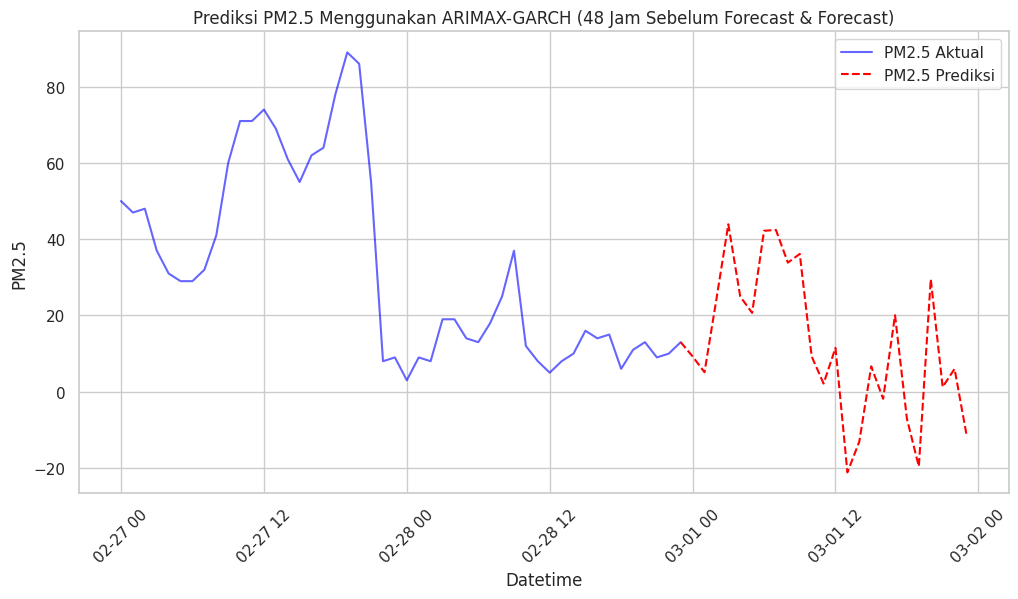

In [ ]:
sns.set(style="whitegrid")

# Ambil data 48 jam sebelum forecast
historical_window = 48
data_historical = dataDingling.iloc[-historical_window:]

# Gabungkan titik terakhir data historis dengan titik pertama prediksi
last_actual_time = data_historical.index[-1]
first_pred_time = prediksi_df["Tanggal"].iloc[0]
if last_actual_time != first_pred_time:
    bridging_point = pd.DataFrame({
        "Tanggal": [last_actual_time],
        "Prediksi_Y": [data_historical["PM2.5"].iloc[-1]]
    })
    prediksi_df = pd.concat([bridging_point, prediksi_df], ignore_index=True)

# Plot data historis PM2.5
plt.figure(figsize=(12, 6))
plt.plot(data_historical.index, data_historical["PM2.5"], label="PM2.5 Aktual", color="blue", alpha=0.6)

# Plot hasil prediksi PM2.5
plt.plot(prediksi_df["Tanggal"], prediksi_df["Prediksi_Y"], label="PM2.5 Prediksi", color="red", linestyle="dashed")

# Label dan judul
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.title("Prediksi PM2.5 Menggunakan ARIMAX-EGARCH (48 Jam Sebelum Forecast & Forecast)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Pada hasil prediksi yang diperoleh dari model ARIMAX-EGARCH, terlihat bahwa terdapat fluktuasi yang cukup signifikan pada 24 jam periode ke depan. Namun, terlihat pula nilai prediksi cenderung kurang tepat walaupun volatilitas dari data terlihat bervariasi. Hal ini dapat terjadi karena model ARIMAX yang dibentuk belum cukup baik untuk menangkap pola data. Kondisi ini ditinjau melalui nilai PM2.5 yang berada di nilai negatif.

## Conclusion

- **Apakah terdapat pola harian dan musiman dalam data polusi udara yang ditinjau dari PM2.5 untuk setiap stasiun amatan?**<br>
-> Berdasarkan analisis yang dilakukan terhadap data pada masing-masing stasiun, terdapat pola yang berfluktuasi untuk periode harian. Hal ini dapat terjadi karena aktivitas yang cenderung berubah-ubah setiap harinya. Kondisi seperti hari kerja, hari libur, serta acara besar menjadi faktor yang mempengaruhi perubahan nilai PM2.5 untuk masing-masing stasiun amatan selama periode yang diamati. Selain itu pada data tersebut saat diukur secara rata-rata bulanan terlihat bahwa nilai PM2.5 cenderung turun di bulan agustus dan naik kembali hingga bulan desember. Akhir tahun dan Awal tahun cenderung menunjukkan nilai PM2.5 yang cukup tinggi karena aktivitas mobilisasi yang cukup tinggi. Selain itu, saat ditinjau untuk setiap wilayah, diperoleh bahwa wilayah Dingling memiliki kondisi PM2.5 yang lebih buruk dibanding wilayah lainnya, karena intensitas jumlah kategori udara tidak baik lebih tinggi.

- **Apakah terdapat hubungan antara variabel meteorologi lain dengan perubahan pada variabel PM2.5?**<br>
-> Variabel meteorologi lain memiliki hubungan dengan PM2.5. Hal ini ditunjukkan oleh korelasi linier ynag cukup tinggi antara SO2, NO2, CO. Selain itu variabel Wind Speed, Temperature, hingga Dewpoint memiliki korelasi dengan PM2.5 walaupun tidak begitu besar.

- **Bagaimana sebaran kategori PM2.5 untuk Stasiun Dingling setiap harinya?**<br>
->Berdasarkan visualisasi heatmap yang dipilih, diharapkan identifikasi sebaran pengklasifikasian dari PM2.5 lebih mudah. Hal ini dikarenakan layout yang digunakan pada heatmap mengikuti konsep tanggal pada kalender serta disertai legenda yang menunjukkan batasan tertentu untuk kualitas udara. Warna yang digunakan juga dapat menjelasakan skala bahaya dari kondisi kualitas udara yang diukur dari PM2.5 harian di periode tertentu

- **Analisis Lanjutan membentuk model prediksi untuk nilai PM2.5 di Stasiun Dingling**
-> Berdasarkan model yang diperoleh terlihat bahwa data PM2.5 pada skala jam memiliki kondisi heteroskedastisitas yaitu variabilitas yang cukup tinggi. Hal ini umum terjadi karena data untuk skala jam menggambarkan variasi aktivitas dari masyrakat di periode itu. Seperti bekerja, berolahraga, istirahat, bersekolah, hingga bermain. Selain itu diperkirakan terjadi fluktuasi pada periode kedepan mengacu pada model yang diperoleh. Oleh karena itu, masyarakat dapat meminimalisir aktivitas yang tidak penting di periode terkait.